# Text Classification With Hidden State

Here we are going to do some text classification based on a hiddenstate of a transformer(BERT) language model.

This can be a form of transfer-learning, but we do not finetune the model with the new data. Instead, we extract features from the lanhuage model & use simple LinearRegression model for the classification task.

In [1]:
!pip install transformers datasets umap-learn sklearn

## Load the Dataset

Here we are going to load the following dataset with some [twitter data](https://huggingface.co/datasets/tweet_eval).

In [2]:
from datasets import load_dataset

In [3]:
ds_emotions = load_dataset("tweet_eval", "emotion")
ds_emotions

Found cached dataset tweet_eval (/home/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343)


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 3257
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1421
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 374
    })
})

In [4]:
ds_train = ds_emotions["train"]
ds_valid = ds_emotions["validation"]

In [5]:
ds_train[0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': 2}

In [6]:
ds_train.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['anger', 'joy', 'optimism', 'sadness'], id=None)}

In [7]:
ds_train["text"][0:5]

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs",
 "No but that's so cute. Atsu was probably shy about photos before but cherry helped her out uwu",
 "Rooneys fucking untouchable isn't he? Been fucking dreadful again, depay has looked decent(ish)tonight",
 "it's pretty depressing when u hit pan on ur favourite highlighter"]

In [8]:
ds_train["label"][0:5]

[2, 0, 1, 0, 3]

## Data Visualization

It's a super idea to see what's going on here in our dataset. So, let's convert this dataset to pandas & try to visualize it a bit.

In [9]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
ds_train.set_format(type="pandas")

In [11]:
df = ds_train[:]
df.head()

,text,label
0,“Worry is a down payment on a problem you may ...,2
1,My roommate: it's okay that we can't spell bec...,0
2,No but that's so cute. Atsu was probably shy a...,1
3,Rooneys fucking untouchable isn't he? Been fuc...,0
4,it's pretty depressing when u hit pan on ur fa...,3


In [12]:
## let's add a text columns as the label
df["label_text"] = df["label"].apply(lambda x: ds_train.features["label"].int2str(x))
df.head(10)

,text,label,label_text
0,“Worry is a down payment on a problem you may ...,2,optimism
1,My roommate: it's okay that we can't spell bec...,0,anger
2,No but that's so cute. Atsu was probably shy a...,1,joy
3,Rooneys fucking untouchable isn't he? Been fuc...,0,anger
4,it's pretty depressing when u hit pan on ur fa...,3,sadness
5,@user but your pussy was weak from what I hear...,0,anger
6,Making that yearly transition from excited and...,3,sadness
7,Tiller and breezy should do a collab album. Ra...,1,joy
8,@user broadband is shocking regretting signing...,0,anger
9,@user Look at those teef! #growl,0,anger


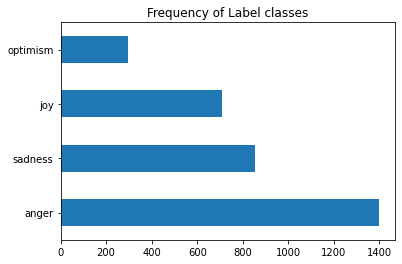

In [13]:
## Visalizing label's class distribution
df["label_text"].value_counts().plot.barh()
plt.title("Frequency of Label classes")
plt.show()

**Based on this, it's clear that we have more anger, sadness  tweets.**

If we have imblance classes, we should try to use a tool like [imbalance-learn](https://imbalanced-learn.org/stable/introduction.html) for any sort of production use.

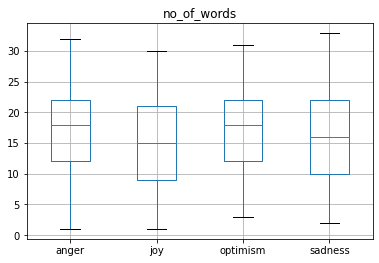

In [14]:
## Plotting the number of words in text
df["no_of_words"] = df["text"].str.split().apply(len)
df.boxplot(column=["no_of_words"], by=["label_text"])
plt.suptitle("")
plt.xlabel("")
plt.show()

**Okay. No of words are under 25 for most of the cases. So, we don't have issues with no of tokens in these tweets.**
<br/>
That's because there are some limitations for the lenght of tokens.

## Tokenizing

Here we use the tokenizer used in Bert called [WordPiece](https://ai.googleblog.com/2021/12/a-fast-wordpiece-tokenization-system.html).
It's mix of both word & character based tokenizer.

In [15]:
from transformers import AutoTokenizer

In [16]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

### Info about the Tokenizer

In [17]:
tokenizer.vocab_size

30522

In [18]:
tokenizer.model_max_length

512

In [19]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

### Tokenizing

In [20]:
ds_train.reset_format()

In [21]:
sample_text = ds_train[0:2]["text"]
sample_text

["“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 "My roommate: it's okay that we can't spell because we have autocorrect. #terrible #firstworldprobs"]

In [22]:
encoded_texts = tokenizer(sample_text, truncation=True, padding=True)
encoded_texts

{'input_ids': [[101, 1523, 4737, 2003, 1037, 2091, 7909, 2006, 1037, 3291, 2017, 2089, 2196, 2031, 1005, 1012, 11830, 11527, 1012, 1001, 14354, 1001, 4105, 1001, 4737, 102, 0, 0, 0, 0], [101, 2026, 18328, 1024, 2009, 1005, 1055, 3100, 2008, 2057, 2064, 1005, 1056, 6297, 2138, 2057, 2031, 8285, 27108, 2890, 6593, 1012, 1001, 6659, 1001, 2034, 11108, 21572, 5910, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

As you can see, tokenizing convert them into **input_ids** and **attention_mask**.
<br/>
Here we do padding and `attention_mask` makes sure those padding won't affect when calculating the attention logic.

### Converting ids back to tokens & text

In [23]:
# Here's how to converts ids into tokens
sample_tokens = tokenizer.convert_ids_to_tokens(encoded_texts["input_ids"][0])
print(sample_tokens)

['[CLS]', '“', 'worry', 'is', 'a', 'down', 'payment', 'on', 'a', 'problem', 'you', 'may', 'never', 'have', "'", '.', 'joyce', 'meyer', '.', '#', 'motivation', '#', 'leadership', '#', 'worry', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]']


In [24]:
# Here's how to convert tokens into strings
tokenizer.convert_tokens_to_string(sample_tokens)

"[CLS] “ worry is a down payment on a problem you may never have '. joyce meyer. # motivation # leadership # worry [SEP] [PAD] [PAD] [PAD] [PAD]"

In [25]:
ds_train[0]

{'text': "“Worry is a down payment on a problem you may never have'. \xa0Joyce Meyer.  #motivation #leadership #worry",
 'label': 2}

## Loading the Hidden State

In [26]:
device = "cuda"

In [27]:
from transformers import AutoModel, DistilBertModel
import torch
import numpy as np

In [28]:
model = AutoModel.from_pretrained(model_name).to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Trying out the model

In [29]:
token_infos = tokenizer(sample_text, padding=True, truncation=True)
inputs = {k:torch.tensor(v).to(device) for k,v in token_infos.items()}
inputs["input_ids"].shape, inputs["attention_mask"].shape

(torch.Size([2, 30]), torch.Size([2, 30]))

In [30]:
with torch.no_grad():
    sample_hidden_state = model(**inputs).last_hidden_state
sample_hidden_state.shape

torch.Size([2, 30, 768])

Here, we got 30 as the dimention because the sequence lenght of these inputs is **30**.
But, we only need a single set of features only.

So, in this case we will pick the first item. That's fine because all the words in the sequence will be used to calculate the attention.

In [31]:
## So, our hidden state will be
sample_hidden_state[:, 0, :].shape

torch.Size([2, 768])

### Get All Hidden States

In [32]:
ds_train.set_format("torch")

In [33]:
def extract_hidden_state(a):
    token_info = tokenizer(a["text"], padding=True, truncation=True)
    input_ids = torch.tensor(token_info.input_ids).to(device)
    attention_mask = torch.tensor(token_info.attention_mask).to(device)
    
    hidden_state = model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
    return {"hidden_state": hidden_state}
    
ds_train_with_hidden = ds_emotions.map(extract_hidden_state, batched=True, batch_size=64)

Loading cached processed dataset at /home/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-e5c92de8fc114c23.arrow
Loading cached processed dataset at /home/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-a805e0144ab43c5e.arrow
Loading cached processed dataset at /home/.cache/huggingface/datasets/tweet_eval/emotion/1.1.0/12aee5282b8784f3e95459466db4cdf45c6bf49719c25cdb0743d71ed0410343/cache-563eb4c5110b2268.arrow


In [34]:
ds_train_with_hidden["train"][0:10]["hidden_state"].shape

torch.Size([10, 768])

## Visualizing Hidden State & Labels

Before we do any sorts of training, it's good idea to visualize our dataset.

Since we use our hidden state as features, we got abour **768** features. So, we need some way to visualize these.

In [35]:
X_train = ds_train_with_hidden["train"]["hidden_state"].numpy()
Y_train = ds_train_with_hidden["train"]["label"].numpy()

X_train.shape, Y_train.shape

((3257, 768), (3257,))

In [36]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

In [40]:
# Get X_train features into 0-1 range
X_train_uniform = MinMaxScaler().fit_transform(X_train)

In [42]:
# Create the mapping
mapper = UMAP(n_components=2, metric="cosine").fit(X_train_uniform)

In [52]:
# Move this into a dataframe
df_train = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_train["label"] = Y_train

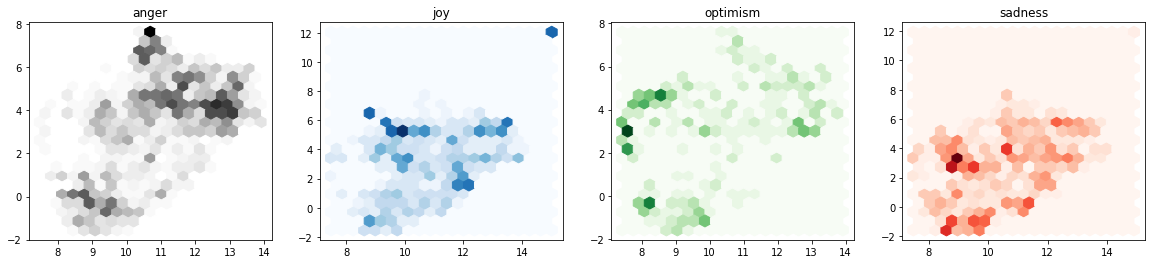

In [94]:
# Let's plot these
labels = ds_train.features['label'].names
cmaps = ["Greys", "Blues", "Greens", "Reds"]

fig, ax = plt.subplots(1, 4, figsize=(20, 4))

for index, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_label = df_train.query(f"label == {index}")
    ax[index].hexbin(df_label["X"], df_label["Y"], gridsize=20, cmap=cmap)
    ax[index].set_title(label)

**Yep.**

They seems to have some sort of different clusterization. Hope we can do something great with a decent classifier.